# Berater Environment v13 (Orso's live)

## Changes from v12 (work in progress)
* migration to easyagents
* Max. number of steps management and debug logging migrated to easyagents.TrainingDuration
* render yields the last step, supporting modes 'ansi', 'human', 'rgb_array'
* the story of Orso
* image rendering in graph layout
* plot statistics and state during training

### Install gym, tensorflow, tf-agents,..., setup display

In [ ]:
!pip install -q easyagents
!pip install -q networkx==2.3.0 

##### suppress package warnings, in colab: load additional packages for rendering

In [1]:
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install -q pyvirtualdisplay    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

# Define Gym Environment

### Imports

In [2]:
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

### Helper methods

In [3]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

### Berater Environment (OpenAI Gym)

In [4]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions:
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        #         self.map = {
        #             'S': [('A', 100), ('B', 400), ('C', 200 )],
        #             'A': [('B', 250), ('C', 400), ('S', 100 )],
        #             'B': [('A', 250), ('C', 250), ('S', 400 )],
        #             'C': [('A', 400), ('B', 250), ('S', 200 )]
        #         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/images/"
        self.image_orso = mpi.imread(base + "Bear.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = 0
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for target, cost in connections:
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                nx_graph.add_edge(source, target, color=color, weight=6, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure("BeraterEnv", figsize=(12, 9))
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]
        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax,
                edges=edges, edge_color=edge_colors, width=edge_weights)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            node['image'] = self.image_empty_pot
            if self.customer_reward[node_id] > 0:
                node['image'] = self.image_honey
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            xp, yp = self.nx_pos[n]
            offset_image = OffsetImage(self.nx_graph.node[n]['image'], self.nx_graph.node[n]['zoom'])
            offset_image.image.axes = ax
            ab = AnnotationBbox(offset_image, (xp, yp),
                                xybox=(0, 0),
                                xycoords='data',
                                boxcoords="offset points",
                                pad=0.0,
                                frameon=False
                                )
            ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure()
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

# First Steps
A way to view the visualization: 

Orso - the bear - lives in his cave (position 'S'). Orso knows his area and where he can 
typically find some honey (positions 'A' to 'O'). The honey places are scattered all over his home turf and connected
by some pathways. Some connections are easy like walking over a grassy field (light green, very low cost) or forests 
(dark green, low cost), a bit strenuous like walking over a hill (brown, higher costs) and very arduous like swimming 
through a lake (blue, very high costs).

There are other bears around competing for the honey pots. So some spots have honey (yellow nodes) and some
are already taken (brown nodes).

Every morning, Orso awakes and starts looking for some honey. But every day, the honey pots are at a new place
( env.reset() ). So Orso climbs a tree near his cave to find out where the honey is. Even with this knowledge it is not clear which route he should take. Being a bear also means being lazy, so Orso wants to get as much honey as possible while at the lowest costs possible. At each spot he has to decide where to go next (the action). His daily journey ends when his back in his own cave.

Be god and create Orso's world:

In [5]:
b = BeraterEnv()

A new morning starts (rerun the cell below to see how the honey pots change places). But Orso 
(depicted in 'fuchsia', Marsha's favorite color ?) doesn't know 
about the sweetness of honey or his surroundings. So the climbs a tree to get an overview and this is what he sees:

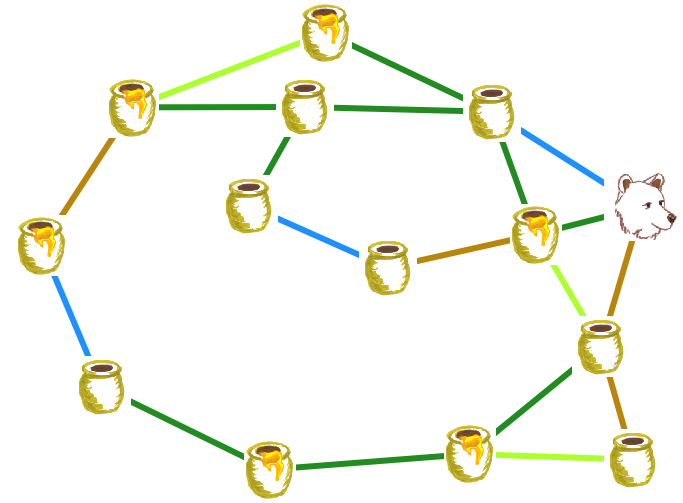

In [6]:
b.reset()
b.render() 

Take Orso by his paws and go for a few steps:

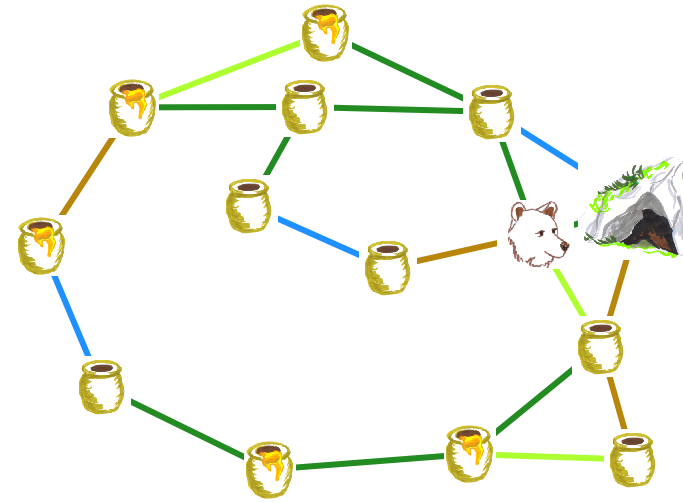

In [7]:
b.step(1)
print(b.render(mode='ansi'))
b.render()


Note that the honey pot nodes turn brown once Orso has passed and taken the honey.

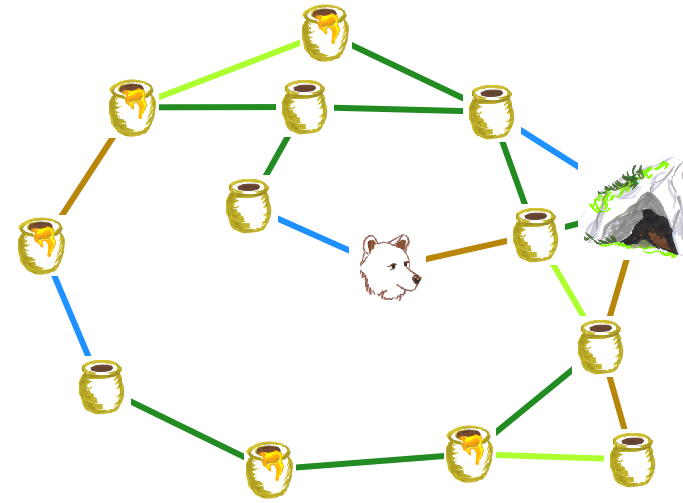

In [8]:
b.step(3)
print(b.render(mode='ansi'))
b.render()

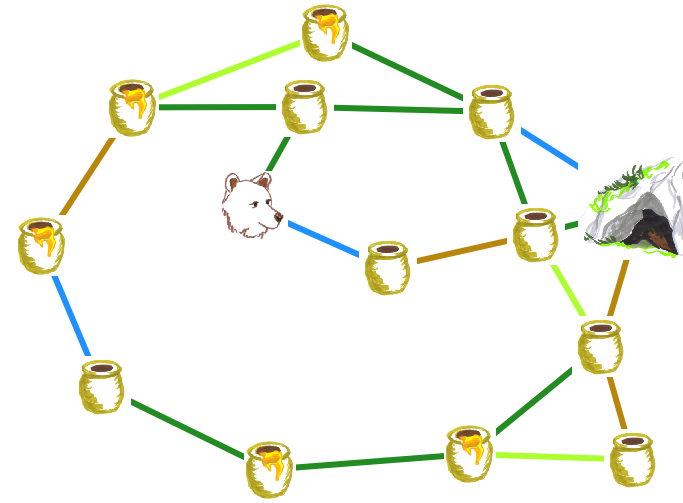

In [9]:
b.step(1)
print(b.render(mode='ansi'))
b.render()

Now Orso must start to learn by himself to take actions to gather all the honey while minimizing the effort:

# Train policy with tfagents PpoAgent

### Register with OpenAI Gym

In [10]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


##  Dry run (short training, no logging)

In [11]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingFast
from easyagents.config import Logging

import tensorflow as tf
import matplotlib.pyplot as plt

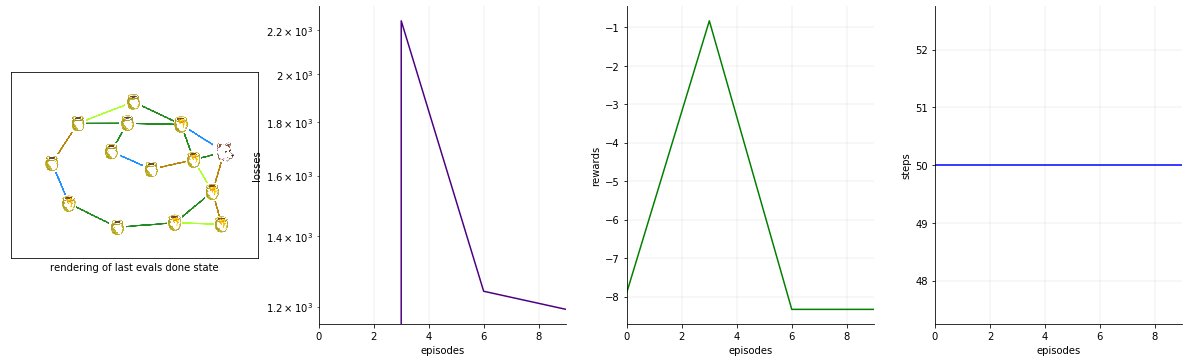

In [12]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',                        
                        training=TrainingFast(max_steps_per_episode = 50))
ppoAgent.train()

## Some training & logging (default, on custom network)

In [15]:
from easyagents.tfagents import PpoAgent
from easyagents.config import Training

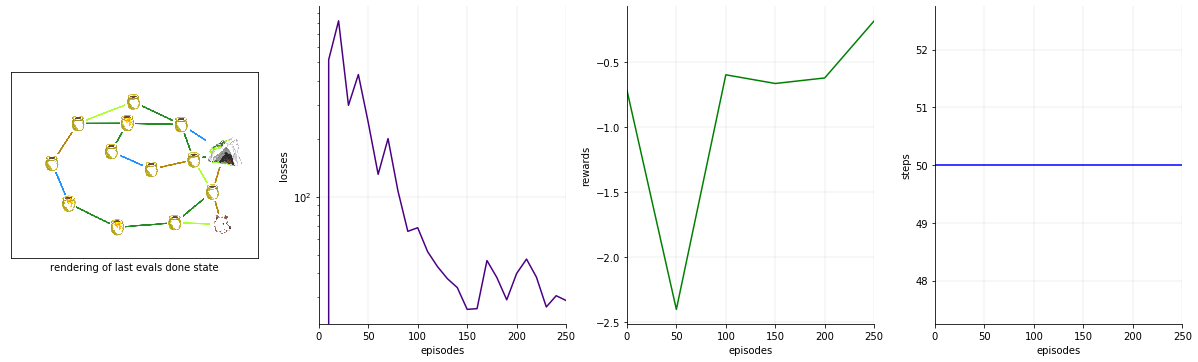

In [16]:
ppoAgent = PpoAgent( gym_env_name = 'Berater-v1', fc_layers=(500,500,500), 
                     training=Training(max_steps_per_episode = 50) )
ppoAgent.train()

### Visualize (console and movie)

In [ ]:
ppoAgent.render_episodes(num_episodes=1,mode='ansi')

In [ ]:
ppoAgent.render_episodes_to_jupyter(num_episodes=1, fps=1)

## Custom training (duration, learning rate)

In [ ]:
from easyagents.tfagents import PpoAgent
from easyagents.config import Training

In [ ]:
training=Training( num_iterations = 2500,
                   num_episodes_per_iteration = 10,
                   max_steps_per_episode = 50,
                   num_epochs_per_iteration = 5 )

In [ ]:
%%time

ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training=training,
                        learning_rate=1e-4
                   )
ppoAgent.train()

### Visualize (with custom y-limits and movie)

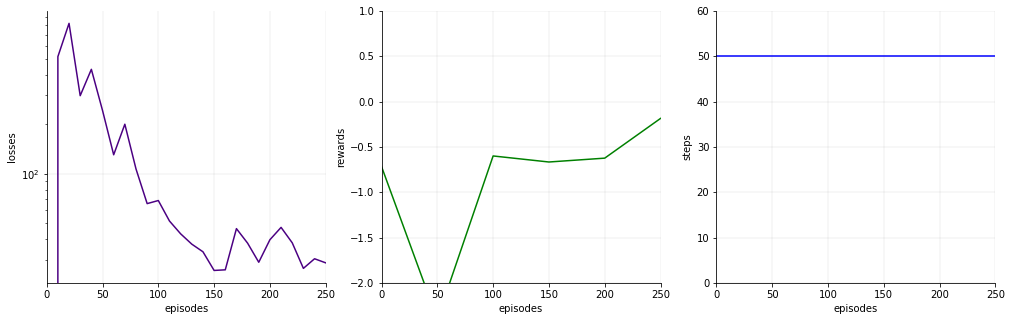

In [23]:
_ = ppoAgent.plot_episodes(ylim=[None,(-2,1),(0,60)])

In [ ]:
ppoAgent.render_episodes_to_jupyter(num_episodes=1, fps=1)